<a href="https://colab.research.google.com/github/kmahatma/base-code-ml/blob/gh-pages/t3_w12_modern_cnn_densenet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


Modern CNN - AlexNet

theory : https://d2l.ai/chapter_convolutional-modern/densenet.html#
Source : https://github.com/d2l-ai/d2l-en/blob/master/chapter_convolutional-modern/densenet.md

In [ ]:
!pip install d2l==0.17.0

As shown in Fig. 7.7.1, the key difference between ResNet and DenseNet is that in the latter case outputs are **concatenated** (denoted by  [,] ) rather than added. 

As a result, we perform a mapping from  x  to its values after applying an increasingly complex sequence of functions:

x→[x,f1(x),f2([x,f1(x)]),f3([x,f1(x),f2([x,f1(x)])]),…].
 
In the end, all these functions are combined in MLP to reduce the number of features again. In terms of implementation this is quite simple: rather than adding terms, we concatenate them. The name DenseNet arises from the fact that the dependency graph between variables becomes quite dense. The last layer of such a chain is densely connected to all previous layers

7.7.2. Dense Blocks

DenseNet uses the modified “batch normalization, activation, and convolution” structure of ResNet (see the exercise in Section 7.6). First, we implement this convolution block structure.

In [2]:
import torch
from torch import nn
from d2l import torch as d2l


def conv_block(input_channels, num_channels):
    return nn.Sequential(
        nn.BatchNorm2d(input_channels), nn.ReLU(),
        nn.Conv2d(input_channels, num_channels, kernel_size=3, padding=1))

In [3]:
class DenseBlock(nn.Module):
    def __init__(self, num_convs, input_channels, num_channels):
        super(DenseBlock, self).__init__()
        layer = []
        for i in range(num_convs):
            layer.append(conv_block(
                num_channels * i + input_channels, num_channels))
        self.net = nn.Sequential(*layer)

    def forward(self, X):
        for blk in self.net:
            Y = blk(X)
            # Concatenate the input and output of each block on the channel
            # dimension
            X = torch.cat((X, Y), dim=1)
        return X

In the following example, we define a DenseBlock instance with 2 convolution blocks of 10 output channels. 

When using an input with 3 channels, we will get an output with  3+2×10=23  channels. The number of convolution block channels controls the growth in the number of output channels relative to the number of input channels. This is also referred to as the growth rate.

In [4]:
blk = DenseBlock(2, 3, 10)
X = torch.randn(4, 3, 8, 8)
Y = blk(X)
Y.shape

torch.Size([4, 23, 8, 8])

**7.7.3. Transition Layers**

Since each dense block will increase the number of channels, adding too many of them will lead to an excessively complex model. A transition layer is used **to control the complexity of the model**. It reduces the number of channels by using the  1×1  convolutional layer and halves the height and width of the average pooling layer with a stride of 2, further reducing the complexity of the model.

In [5]:
def transition_block(input_channels, num_channels):
    return nn.Sequential(
        nn.BatchNorm2d(input_channels), nn.ReLU(),
        nn.Conv2d(input_channels, num_channels, kernel_size=1),
        nn.AvgPool2d(kernel_size=2, stride=2))

Apply a transition layer with 10 channels to the output of the dense block in the previous example. This reduces the number of output channels to 10, and halves the height and width.

In [6]:
blk = transition_block(23, 10)
blk(Y).shape

torch.Size([4, 10, 4, 4])

**7.7.4. DenseNet Model**

Next, we will construct a DenseNet model. DenseNet first uses the same single convolutional layer and maximum pooling layer as in ResNet.

In [7]:
b1 = nn.Sequential(
    nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3),
    nn.BatchNorm2d(64), nn.ReLU(),
    nn.MaxPool2d(kernel_size=3, stride=2, padding=1))

Then, similar to the four modules made up of residual blocks that ResNet uses, DenseNet **uses four dense blocks**. Similar to ResNet, we can set the number of convolutional layers used in each dense block.  

Furthermore, we set the number of channels (i.e., growth rate) for the convolutional layers in the dense block to 32, so 128 channels will be added to each dense block.

In ResNet, the height and width are reduced between each module by a residual block with a stride of 2. Here, **we use the transition layer to halve the height and width and halve the number of channels.**

In [8]:
# `num_channels`: the current number of channels
num_channels, growth_rate = 64, 32
num_convs_in_dense_blocks = [4, 4, 4, 4]
blks = []
for i, num_convs in enumerate(num_convs_in_dense_blocks):
    blks.append(DenseBlock(num_convs, num_channels, growth_rate))
    # This is the number of output channels in the previous dense block
    num_channels += num_convs * growth_rate
    # A transition layer that halves the number of channels is added between
    # the dense blocks
    if i != len(num_convs_in_dense_blocks) - 1:
        blks.append(transition_block(num_channels, num_channels // 2))
        num_channels = num_channels // 2

Similar to ResNet, a global pooling layer and a fully-connected layer are connected at the end to produce the output.

In [9]:
net = nn.Sequential(
    b1, *blks,
    nn.BatchNorm2d(num_channels), 
    nn.ReLU(),
    nn.AdaptiveMaxPool2d((1, 1)),
    nn.Flatten(),
    nn.Linear(num_channels, 10))

**7.7.5. Training**

Since we are using a deeper network here, in this section, we will reduce the input height and width of the Fashion MNIST data from 224 to 96 to simplify the computation.

loss 0.145, train acc 0.947, test acc 0.901
794.9 examples/sec on cuda:0


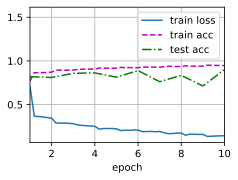

In [10]:
lr, num_epochs, batch_size = 0.1, 10, 256
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size, resize=96)
d2l.train_ch6(net, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())

**7.7.6. Summary**

In terms of cross-layer connections, unlike ResNet, where inputs and outputs are added together, **DenseNet concatenates inputs and outputs on the channel dimension.**

The main components that compose DenseNet are **dense blocks and transition layers.**

We need to keep the dimensionality under control when composing the network by adding transition layers that shrink the number of channels again.